# Deep Learning: Classifying EMNIST Letters

## 🎯 Objective
We have mastered digits (MNIST); now let's scale up to the alphabet. In this notebook, we tackle the **EMNIST (Extended MNIST)** dataset, focusing on the "Letters" split. This dataset presents new challenges: it contains more classes (26 letters), has some unique data quirks (rotated images, unused classes), and requires a slightly more robust model. We will introduce **Batch Normalization** and **Leaky ReLU** to handle this increased complexity.

## 📚 Key Concepts
* **EMNIST:** A drop-in replacement for MNIST containing handwritten characters. We use the 'letters' split.
* **Batch Normalization (`nn.BatchNorm2d`):** A technique that normalizes the inputs to a layer for every mini-batch. This stabilizes learning and allows for higher learning rates.
* **Leaky ReLU:** A variation of ReLU that allows a small, non-zero gradient when the unit is not active ($x < 0$). This helps prevent "dead neurons" during training.
* **Data Cleaning:** Real-world data is rarely perfect. We will manually fix class indexing and image orientation issues.

## 1. Import Libraries

We import our standard PyTorch stack.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torchvision

import matplotlib.pyplot as plt

## 2. Load and Inspect Data

We download the EMNIST dataset. Note that we specify `split="letters"`. 

### Data Dimensions
Unlike MNIST (60k images), EMNIST 'letters' has **124,800 images**. We need to reshape this flat data into the 4D tensor format `(N, Channels, Height, Width)` expected by PyTorch CNNs.

In [2]:
### Import and inspect the data
cdata = torchvision.datasets.EMNIST(root="emnist", split= "letters", download = True)

In [3]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


## 3. Data Cleaning

Upon inspection, we find a quirk: the classes include "N/A", and the numerical labels range from 1 to 26 (instead of 0 to 25). This causes issues for PyTorch's CrossEntropyLoss, which expects 0-indexed labels.

**The Fix:** We remove the "N/A" class and subtract 1 from all target labels.

In [4]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [5]:
cdata.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [6]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels = cdata.targets -1
print(labels.shape)

### 
print( torch.sum(labels==0) )
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

## 4. Normalization and Visualization

Raw pixel values are integers [0, 255]. We normalize them to the float range [0, 1] for better training stability.

### The Orientation Issue
When we visualize the images, you will notice they are flipped and rotated. This is a known issue with how EMNIST is stored. In the visualization loop, we use `.T` (transpose) to fix this for display, but the model will learn to recognize them in their raw format (or we could transpose the dataset itself).

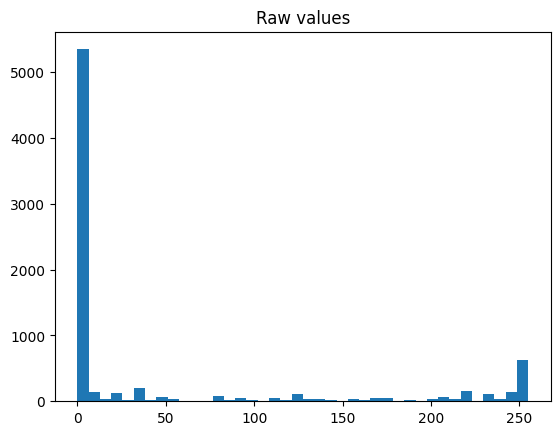

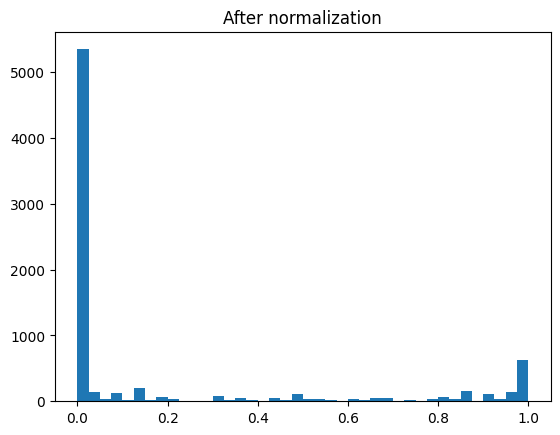

In [7]:
# next issue: do we need to normalize the images?
plt.hist(images[:10, :, :, :].flatten(),40);
plt.title('Raw values')
plt.show()

# yarp.
images /= torch.max(images)

plt.hist(images[:10, :, :, :].flatten(),40);
plt.title('After normalization')
plt.show()

/tmp/ipython-input-4227174864.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4416.)
  ax.imshow(I.T,cmap='gray')


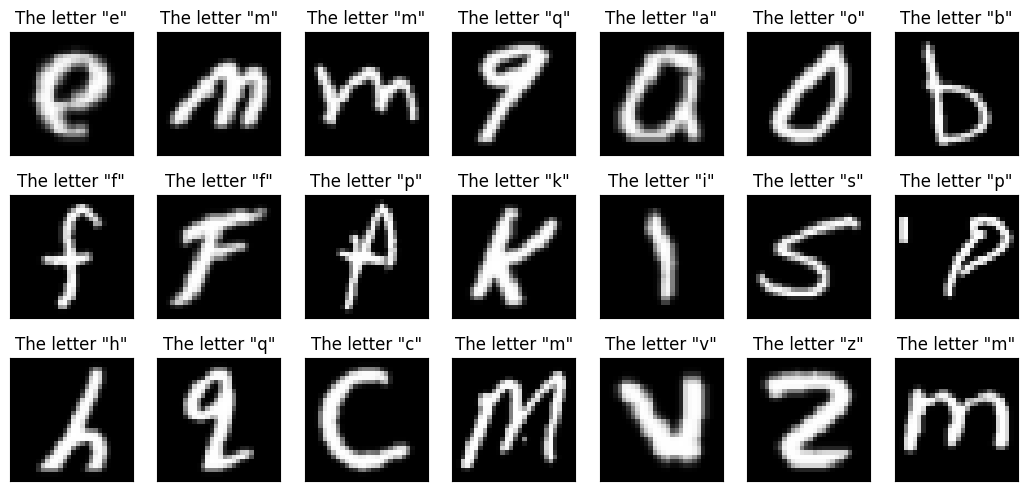

In [8]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):

  # pick a random pic
  whichpic = np.random.randint(images.shape[0])
  
  # extract the image and its target letter
  I = images[whichpic]
  letter = letterCategories[labels[whichpic]]
  
  # visualize
  ax.imshow(I.T,cmap='gray')
  ax.set_title(f'The letter "{letter}"')
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

## 5. Creating DataLoaders

We perform a standard train/test split (90/10) and wrap the data in DataLoaders.

In [9]:
### Create train/test split groups using DataLoaders

# using sklearn to split data
train_data, test_data, train_lable, test_lable = train_test_split(images, labels, test_size= 0.1)

# convert into pyTorch Datasets
train_dataset = TensorDataset(train_data, train_lable)
test_dataset = TensorDataset(test_data, test_lable)

# convert into DataLoader Objects
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size = test_dataset.tensors[0].shape[0])

In [10]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


## 6. Model Architecture: Adding Stability

We upgrade our standard CNN with two powerful features:

1.  **Batch Normalization (`BatchNorm2d`):** Added after each convolution. It normalizes the activation map (subtracts mean, divides by std) to keep the data distribution stable. This speeds up training.
2.  **Leaky ReLU (`F.leaky_relu`):** Instead of standard ReLU (which outputs 0 for negative inputs), this allows a small negative slope (usually 0.01). This fixes the "dying ReLU" problem where neurons get stuck at 0.

**Structure:** `Conv -> BN -> MaxPool -> LeakyReLU`

In [11]:
### Create the DL Model

def makeTheNet(printToggle = False):
    
    class emnistNet(nn.Module):
        def __init__(self, printToggle):
            super().__init__()
            self.print = printToggle
            
            # convolution layer 1
            self.conv1 = nn.Conv2d(1, 6, 3, padding= 1)
            self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
            # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 cuz pooling)
            
            # convolution layer 2
            self.conv2 = nn.Conv2d(6, 6, 3, padding= 1)
            self.bnorm2 = nn.BatchNorm2d(6)
            # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 cuz pooling)
            
            # linear layer
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(7*7*6, 50)
            self.fc2 = nn.Linear(50, 26)
            
        def forward(self, x):
            
            if self.print: print(f"Input: {list(x.shape)}")
            
            # first conv pool block
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f"First CPR Block: {list(x.shape)}")
            
            # second conv pool block
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f"Second CPR Block: {list(x.shape)}")
            
            # linear layers
            x = self.flatten(x)
            if self.print: print(f"Vectorized: {list(x.shape)}")
            x = F.leaky_relu(self.fc1(x))
            x = F.leaky_relu(self.fc2(x))
            if self.print: print(f"Final Output: {x.shape}")
            return x
        
    
    net = emnistNet(printToggle)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr= 0.001)
    
    return net, lossfun, optimizer

In [12]:
# test the model with one batch
net, lossfun, optimizer = makeTheNet(True)
X,y = next(iter(train_loader))
yHat = net(X)
print(f"Output Size: {yHat.shape}")
loss = lossfun(yHat, y)
print(f"Loss: {loss}")

Input: [32, 1, 28, 28]
First CPR Block: [32, 6, 14, 14]
Second CPR Block: [32, 6, 7, 7]
Vectorized: [32, 294]
Final Output: torch.Size([32, 26])
Output Size: torch.Size([32, 26])
Loss: 3.273235559463501


## 7. Training on GPU

Since the dataset is larger, we add logic to move the computation to a GPU (`cuda`) if available. This drastically reduces training time.

In [13]:
### Create a function to train the model

# use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.inference_mode(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

## 8. Results and Visualization

We inspect the loss curves. A healthy curve decreases rapidly and plateaus. Since this is a harder task than digits, we check if the error rate reaches an acceptable level.

In [15]:
### Run the model and show the results

# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
trainLoss,testLoss,trainErr,testErr,net = function2trainTheModel()

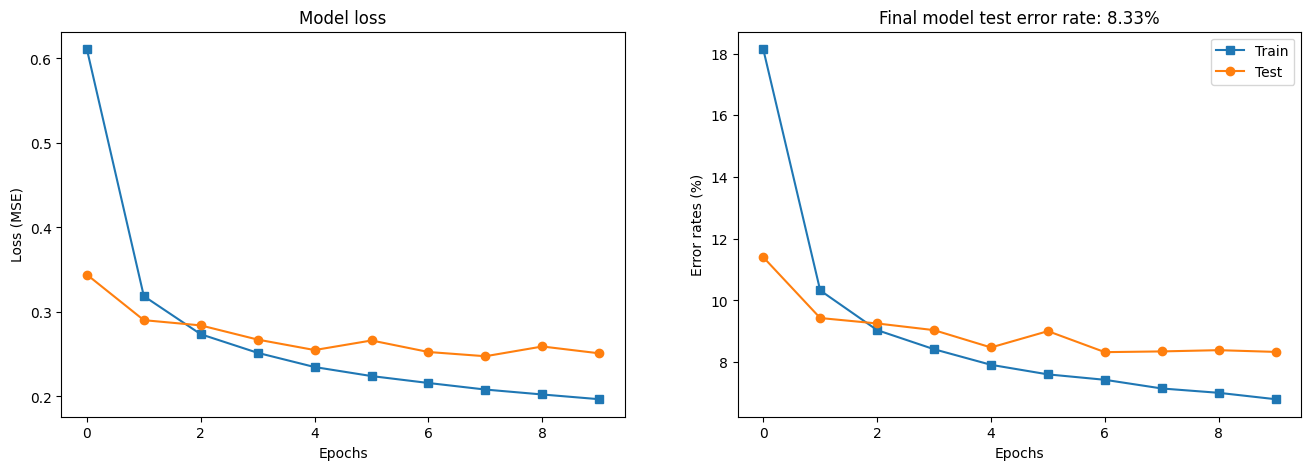

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

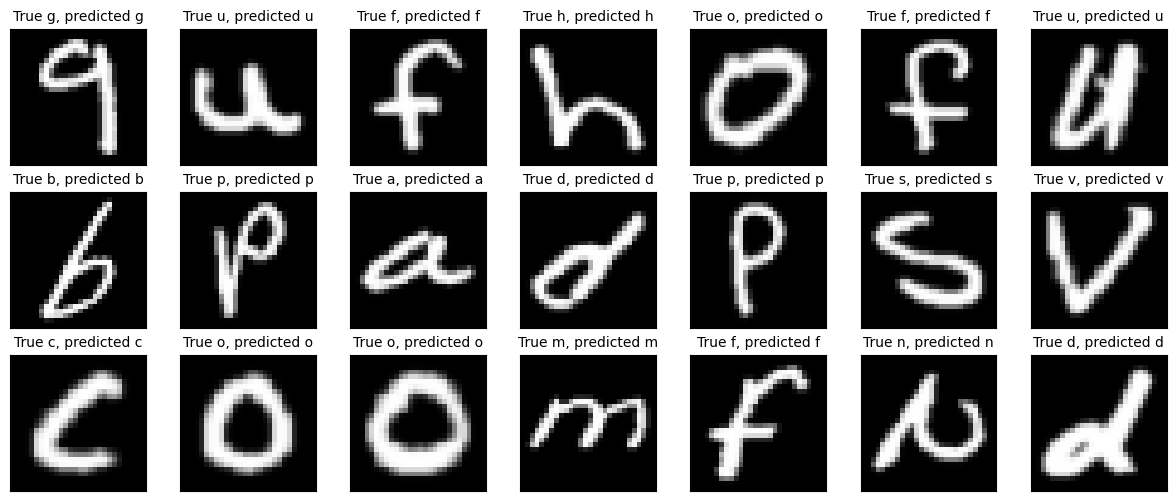

In [17]:
### visualize some images

# extract X,y from test dataloader
X,y = next(iter(test_loader))
X = X.to(device) # push data to GPU
y = y.to(device) # push data to GPU
yHat = net(X)

# pick some examples at random to show
randex = np.random.choice(len(y),size=21,replace=False)

# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,6))

for i,ax in enumerate(axs.flatten()):

  # extract the image and its target letter
  I = np.squeeze( X[randex[i],0,:,:] ).cpu() # .cpu() to transfer back from GPU!
  trueLetter = letterCategories[ y[randex[i]] ]
  predLetter = letterCategories[ torch.argmax(yHat[randex[i],:]) ]
  
  # color-code the accuracy (using ternary operator)
  col = 'gray' if trueLetter==predLetter else 'hot'
  
  # visualize
  ax.imshow(I.T,cmap=col)
  ax.set_title('True %s, predicted %s' %(trueLetter,predLetter),fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

## 9. Error Analysis: Confusion Matrix

Which letters are hardest to distinguish? A confusion matrix helps us see specific weaknesses (e.g., is 'G' often confused with 'Q'?). We use `sklearn` to compute this efficiently.

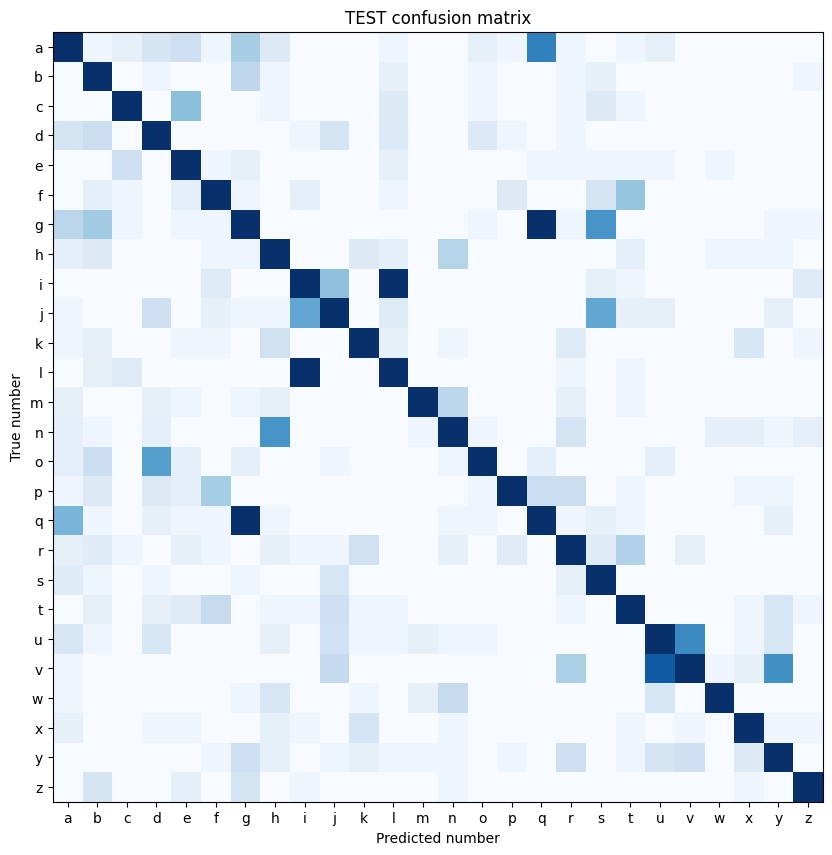

In [18]:
### Accuracy by letter

import sklearn.metrics as skm

# compute the confusion matrix
C = skm.confusion_matrix(y.cpu(),torch.argmax(yHat.cpu(),axis=1),normalize='true')

# visualize it
fig = plt.figure(figsize=(10,10))
plt.imshow(C,'Blues',vmax=.05)

# make the plot look nicer
plt.xticks(range(26),labels=letterCategories)
plt.yticks(range(26),labels=letterCategories)
plt.title('TEST confusion matrix')
plt.xlabel('True number')
plt.xlabel('Predicted number')
plt.ylabel('True number')

plt.show()